# Case Study 3: Spam Classification

#### Team Members:

- Benjamin Goodwin
- Lijju Mathew
- Pradeep Kumar
- Sid Swarupananda

# Business Understanding

Problem Statement:
A huge proportion of email sent globally per day is considered spam, the actual number is nearly 85% of all e-email messages!  (https://dataprot.net/)

Due to this enormous issue, email providers need a consistent way to detect and classify spam and not spam (ham).
A common solution is to use a Naive Bayes classifier to determine which email messages are spam and ham.  

In this case study our goal is to parse email messages and determine which emails are ham and which emails are spam.

Our team has access to a large database of pre-sorted email messages and we will create a custom dataset based on these messages and approach the problem of spam classifcation from a Bayesian perspective.

#### This section handles our imports and libraries

In [1]:
import os
import sklearn
import sys, copy
import pandas as pd
import numpy as np
import matplotlib as plt
sys.path.append('/Users/pradeepkumar/PycharmProjects/QTW/venv/lib/python3.7/site-packages/')
sys.path.append('/Users/pradeepkumar/PycharmProjects/flask/venv/lib/python3.7/site-packages')

from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score
import sklearn
import nltk
import string
import glob
import re
import json
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer


In [3]:
os.getcwd()

'/Users/pradeepkumar/PycharmProjects/flask/venv/SMU_QTW/case_study3'

# Modeling Preperations

Our team was tasked with identifying spam or ham based on a collection of emails (pre-sorted as spam or ham).  Our first task is to add some structure to the data and we will approach this by defining a structure as follows:

Emails have a header and content within the message body- each email is already split into this structure
We will remove all punctuation and stop words as we feel these are not relevant to the classifcation problem at hand. We will continue by stemming to extract the base words.  The classifier will be trained on this newly prepared data and be tasked with generalizing what is to be considered spam and ham.  

As stated above, we will use a Naive Bayes classifer to determine which messages in our test set are spam and ham.  Considering that most email is spam we could create a fairly accurate classifer that simply marks every email as spam, however this would defeat the purpose of email! 

Since this problem is a classication one, we have some options to choose from.  Accuracy is probably not a good metric as we previously stated, however we will need to measure what proportion of predicted Positives is truly Positive? In our case this equates to the percentage of emails flagged as spam (Precision), and commonly associated with precision is recall (Recall measures the percentage of actual spam emails that were correctly classified), thus we will need to observe both.  To consider our model highly successful, we would like both precision and recall to be above 0.7.  Additionally, to get a better overview of these two metrics we will also consider the F1 score, and draw conclusions about the classifer from there.

## Data PreProcessing

#### The ham and spam mails are processed as follows <br> Emails have header and message body content. Each email is split into header and body. <br> All text above the subject line is considered as header and text below subject is considered as body. <br> Punctiations and stop words are removed <br> Stemming is done to extract the base words 


In [4]:
porter = PorterStemmer()

def remove_punct(s1):
    n = ''
    for c in s1:
        if c not in string.punctuation:
            n += c
        else:
            n += ' '
    return n

def remove_stopwords(words):
    stop_words = set(stopwords.words('english'))
    
    filtered_sentence = [w for w in words if not w.lower() in stop_words]
    stemmed_sentence = [porter.stem(w) for w in words]
    
    return ' '.join(stemmed_sentence)
    

def split_header(msg):
    msg_dict = dict()
    
    m1 = re.search('(.*)(subject\s*:.*)', msg, re.I)
    if m1:
        header = m1.group(1).lower()
        body = m1.group(2).lower()
        
        new_header = word_tokenize(remove_punct(header))
        new_body = word_tokenize(remove_punct(body))
        
        new_header1 = remove_stopwords(new_header)
        new_body1 = remove_stopwords(new_body)
        
        
        msg_dict['header'] = new_header1.lower()
        msg_dict['body'] = new_body1.lower()
        
    
    return msg_dict
        

In [5]:
# Seperate the header and message
pdir = ['/Users/pradeepkumar/PycharmProjects/flask/venv/SMU_QTW/case_study3/SpamAssassinMessages/easy_ham',
        '/Users/pradeepkumar/PycharmProjects/flask/venv/SMU_QTW/case_study3/SpamAssassinMessages/spam']

data_dict = dict()
for dname in pdir:
    os.chdir(dname)

    all_files = os.listdir()

    ind=0
    for efile in all_files:
        if 'spam' in dname:
            key = 'spam'
        if 'easy_ham' in dname:
            key = 'ham'
    
        full_msg =''
        with open(efile, mode='r', encoding='ascii', errors='ignore') as fh:
            for line in fh:
                full_msg += line.replace('\n',' ')
        
            data_dict[key+str(ind)] = split_header(full_msg)
            ind += 1
    
df = pd.DataFrame.from_dict(data_dict)
df      

,ham0,ham1,ham2,ham3,ham4,ham5,ham6,ham7,ham8,ham9,...,spam2386,spam2387,spam2388,spam2389,spam2390,spam2391,spam2392,spam2393,spam2394,spam2395
header,from rssfeed jmason org mon sep 30 13 43 46 20...,from fork admin xent com tue sep 3 14 24 41 20...,from fork admin xent com tue sep 24 17 55 30 2...,from rpm list admin freshrpm net mon sep 9 18 ...,from secprog return 625 jm jmason org security...,from exmh user admin redhat com wed sep 11 13 ...,from fork admin xent com mon sep 2 16 22 12 20...,from rssfeed jmason org fri sep 27 10 40 59 20...,from fork admin xent com wed aug 28 17 15 53 2...,from fork admin xent com fri sep 6 11 41 26 20...,...,from 687ifsuy bol com br tue aug 6 12 56 57 20...,return path ler lerami lerctr org deliveri dat...,from vbj101521 caramail com tue aug 27 02 35 2...,from biz2biz2446 flashmail com mon oct 7 22 42...,from mraimecoilcipc msn com mon jul 22 18 39 2...,from safety33o l11 newnamedn com fri aug 23 11...,from fork admin xent com thu aug 8 14 37 34 20...,from niddeel hotmail com tue aug 6 10 54 56 20...,from aileen email2 qve net fri aug 23 11 03 13...,receiv from actioncouri com 207 225 37 163 by ...
body,subject priceless ruben work stolen in raid on...,subject make a mesh on the move messag id pine...,subject re liber defnit to fork spamassassin t...,subject problem with apt updat messag id 14220...,subject re are bad develop librari the problem...,subject re sort in repli to your messag of tue...,subject re java is for kiddi in repli to ncbbj...,subject skateboard drive through subway with h...,subject re canadian refer 3d6ca455 4010907 per...,subject re ouch bebergflam messag id 200209060...,...,subject best rate on mortgag in the countri da...,subject iso 2022 jp b gyrcjdckocrfjegkyirije4l...,subject custom websit for 399 complet 1709d 5 ...,subject see your compani sale sky rocket 4611 ...,subject fix your credit yourself onlin 12678 d...,subject adv lowest life insur rate avail mood ...,subject new internet servic provid mime versio...,subject bad credit breakthrough 6465 date fri ...,subject get the child support you deserv 11 18...,subject 67 of women say they are unhappi cpbxq...


#### Add a new target column with 1 for spam and 0 for ham 

In [6]:
df1 = df.T
target = df.T.index.tolist()
new_target = list()
for e in target:
    if 'spam' in e:
        new_target.append(1)
    else:
        new_target.append(0)

new_target

df1['target'] = new_target
print(df1.shape)
print(len(new_target))

(7446, 3)
7446


In [7]:
df1
df2 = df1[['header','body']]
df2

,header,body
ham0,from rssfeed jmason org mon sep 30 13 43 46 20...,subject priceless ruben work stolen in raid on...
ham1,from fork admin xent com tue sep 3 14 24 41 20...,subject make a mesh on the move messag id pine...
ham2,from fork admin xent com tue sep 24 17 55 30 2...,subject re liber defnit to fork spamassassin t...
ham3,from rpm list admin freshrpm net mon sep 9 18 ...,subject problem with apt updat messag id 14220...
ham4,from secprog return 625 jm jmason org security...,subject re are bad develop librari the problem...
...,...,...
spam2391,from safety33o l11 newnamedn com fri aug 23 11...,subject adv lowest life insur rate avail mood ...
spam2392,from fork admin xent com thu aug 8 14 37 34 20...,subject new internet servic provid mime versio...
spam2393,from niddeel hotmail com tue aug 6 10 54 56 20...,subject bad credit breakthrough 6465 date fri ...
spam2394,from aileen email2 qve net fri aug 23 11 03 13...,subject get the child support you deserv 11 18...


In [8]:
X = df2.body
y = new_target

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [11]:
type(df1.body)
type(X_train)

pandas.core.series.Series

### Convert the  text to Tf-Idf scores. <br> The output of Tf-Idf vector is a large sparse matrix


In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

def get_tfidf(data):
    vectorizer = TfidfVectorizer(stop_words=None, use_idf=True, norm=None)
    tfidf_vec = vectorizer.fit_transform(data)
    return tfidf_vec

tfidf_body_train = get_tfidf(X_train)
tfidf_body_test = get_tfidf(X_test)


In [13]:
tfidf_body_train

<4988x76341 sparse matrix of type '<class 'numpy.float64'>'
	with 918891 stored elements in Compressed Sparse Row format>

### Reduce the dimension of the sparse Tf-Idf matrix before training the model 

In [14]:
from sklearn.decomposition import TruncatedSVD

def reduce_dim(data):
    svd = TruncatedSVD(n_components=15, n_iter=7, random_state=42)
    transformed = svd.fit_transform(data)
    print(svd.explained_variance_ratio_.sum())
    return transformed

print('Train data , Explained variance', end=' ')
comp_train = reduce_dim(tfidf_body_train)
print('Test data , Explained variance', end=' ')
comp_test = reduce_dim(tfidf_body_test)


Train data , Explained variance 0.7286735688129028
Test data , Explained variance 0.6897200815778456


# Model Building and Evaluation

In this section we will: 

- Look at hierarchical and kmeans clustering
- Train a Naive Bayes model for predicting whether an email observation is Spam or not-Spam (be sure to specify your sampling approach)
- Analyze your model's performance - We will examine precision, recall, and F1 (including supplemental visuals and analysis where appropriate)

### After dimension reduction, With 15 components , we can explain up to 71% of variance in train data

### Check for clustering in data with Hierarchical Clustering Algorithm as below <br> Capping the level of tree at 4, we can see that there are 3 cluster identified based on distances between the Tf-Idf scores of each email body

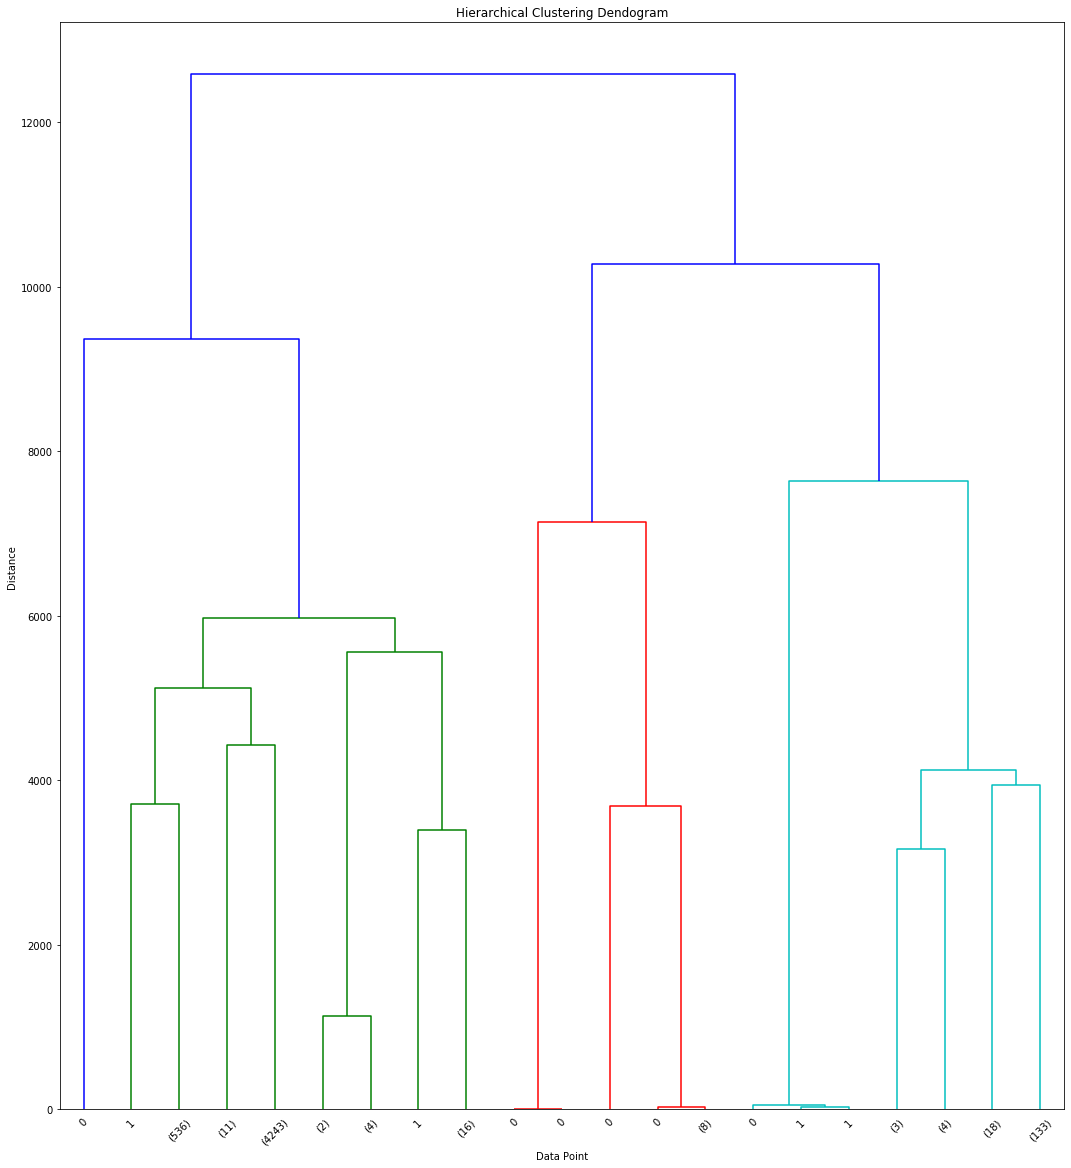

In [15]:
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(comp_train, 'ward')

import matplotlib.pyplot as plt
plt.figure(figsize=(18,20))
plt.title('Hierarchical Clustering Dendogram')
plt.xlabel('Data Point')
plt.ylabel('Distance')
dendrogram(Z, labels=df1.target, p=4, truncate_mode='level', orientation='top')
plt.show()


### With Kmeans clustering, by setting k=2, we can see 2 cluster by using the first 2 dimensions only. <br> There is no clear seperation of data in this cluster

Text(0.5, 1.0, 'Spam and Ham email clusters')

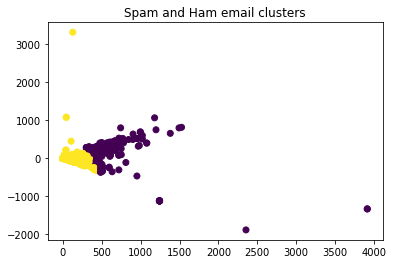

In [16]:
from sklearn.cluster import KMeans
y_pred = KMeans(n_clusters=2, random_state=170).fit_predict(comp_train)

plt.scatter(comp_train[:, 0], comp_train[:, 1], c=y_pred)
plt.title("Spam and Ham email clusters")


<b> Checking for correlation between features </b> <br> <i> From the heat map below , we can see that there is no correlation <br> between features </i>

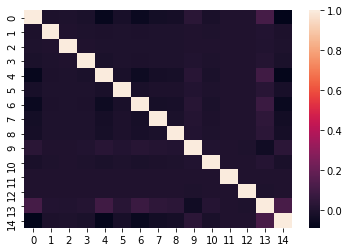

In [17]:
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
corr = np.corrcoef(comp_train, rowvar=False)
corr.shape
sns.heatmap(corr)

<b> Build a Naive Bayes Classifier </b> <br>
<i> Naive Bayes assumes that features are independent which is proved in the heat map above.  30% of data is used for test purpose </i>


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y_pred = gnb.fit(comp_train, y_train).predict(comp_test)
print("Number of mislabeled points out of a total %d points : %d"% (X_test.shape[0], (y_test != y_pred).sum()))


Number of mislabeled points out of a total 2458 points : 750


In [19]:
X_test.shape

(2458,)

In [20]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6948738812042311


In [27]:
# Prediction on a Spam Email 
efile0 = "/Users/pradeepkumar/PycharmProjects/flask/venv/SMU_QTW/case_study3/SpamAssassinMessages/test_mails/test_ham"
efile1 = "/Users/pradeepkumar/PycharmProjects/flask/venv/SMU_QTW/case_study3/SpamAssassinMessages/test_mails/test_spam"
#efile1 = "/Users/pradeepkumar/PycharmProjects/flask/venv/SMU_QTW/case_study3/SpamAssassinMessages/spam/01002.406c1c709e49cb740f0ce36ebf2d5c78"


def open_convert(efile):
    full_msg = ''
    with open(efile, mode='r', encoding='ascii', errors='ignore') as fh:
        for line in fh:
            full_msg += line.replace('\n',' ')
        return split_header(full_msg)

    
df_sample = df1.body.values.tolist()

msg_dict =  open_convert(efile1)      
spam_mail_body = msg_dict['body']
# Make the sample spam mail part of the corpus of emails to get the Tf-Idf score
df_sample.append(spam_mail_body)

msg_dict =  open_convert(efile0)      
ham_mail_body = msg_dict['body']
# Make the sample ham mail part of the corpus of emails to get the Tf-Idf score
df_sample.append(ham_mail_body)

tfidf_sample_trans = reduce_dim(get_tfidf(df_sample))



0.6939942987550731


In [31]:
# Predict on spam email

X_samp = tfidf_sample_trans[-1]
tfidf_sample_trans.shape
X_samp = X_samp.T
B = np.reshape(X_samp, (-1, 1))
X1 = np.ndarray.transpose(B)
X1.shape
gnb.predict(X1)

array([1])

In [29]:
# Predict on ham email

X_samp = tfidf_sample_trans[-2]
X_samp = X_samp.T
type(X_samp)
B = np.reshape(X_samp, (-1, 1))
X1 = np.ndarray.transpose(B)
X1.shape
gnb.predict(X1)

array([0])

<b> Conclusion </b>: After all of our technical analysis and modeling, we are proposing that using a Naive Bayes classifier as a means of spam classification is a feasible task.  Furthermore, moving forward we recommend using our Naive Bayes spam classification system for your business as the metrics we established were met.  Spam classification is  a problem almost as old as the internet itself with the great majority of emails sent daily globally are spam and not ham.  We believe that due to its simplicity and ease of use and history with spam detection, this is the best choice for the issue at hand.  However, there are other more modern approaches to spam classification such as Deep learning, Neural networks, and Support vector machines to name a few, each have their own benefits and costs to consider as alternate approaches to Naive Bayes classification.   All things told, our model performs the task with minimal inputs and classifies emails as spam and not spam!